In [73]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, Input
from keras import metrics
from keras.models import model_from_json
from keras.callbacks import Callback
from keras import optimizers
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [75]:
total_classes = 96

line_folder = "../line_data_4classes"
op_folder = "./result"

X_train = np.load("../line_data" + "/x_train.npy")
y_train_length = np.load(line_folder + "/y_train_length.npy")
y_train_width = np.load(line_folder + "/y_train_width.npy")
y_train_color = np.load(line_folder + "/y_train_color.npy")
y_train_angle = np.load(line_folder + "/y_train_angle.npy")

X_test = np.load("../line_data" + "/x_test.npy")
y_test_length = np.load(line_folder + "/y_test_length.npy")
y_test_width = np.load(line_folder + "/y_test_width.npy")
y_test_color = np.load(line_folder + "/y_test_color.npy")
y_test_angle = np.load(line_folder + "/y_test_angle.npy")

# X_train = X_train[:1000]
# y_train = y_train[:1000]
# X_test = X_test[:1000]
# y_test = y_test[:1000]

print (X_train.shape, X_test.shape, y_train_angle.shape, y_test_angle.shape)

((57600, 28, 28, 3), (38400, 28, 28, 3), (57600, 12), (38400, 12))


In [76]:
X_train = X_train.reshape(57600, 28, 28, 3)
X_test = X_test.reshape(38400, 28, 28, 3)
print (X_train.shape, X_test.shape, y_train_angle.shape, y_test_angle.shape)

((57600, 28, 28, 3), (38400, 28, 28, 3), (57600, 12), (38400, 12))


In [77]:
def getBranch(inp, out_neuron, out_act, name):
    x = Dense(512, activation="relu")(inp)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(out_neuron, activation=out_act, name=name)(x)
    return x

In [161]:
def getCM(y_test, y_pred):
    cm = [[0, 0], [0, 0]]
    for i in range(y_test.size):
        if(y_test[i] == y_pred[i]):
            if(y_test[i] == True):
                cm[1][1] += 1
            else:
                cm[0][0] += 1
        else:
            if(y_test[i] == True):
                cm[0][1] += 1
            else:
                cm[1][0] += 1
    cm = np.array(cm)
    return cm

In [78]:
inp = Input(shape=(28,28,3))
cnn = Conv2D(32, kernel_size=3, strides=1, activation="relu")(inp)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling2D(pool_size=2, strides=1)(cnn)
cnn = Conv2D(8, kernel_size=1, strides=1, activation="relu", input_shape=(28,28,3))(cnn)
cnn = BatchNormalization()(cnn)
cnn = Dropout(rate=0.4)(cnn)
cnn = Flatten()(cnn)

In [82]:
lengthB = getBranch(cnn, 1, "sigmoid", "lengthB")
widthB = getBranch(cnn, 1, "sigmoid", "widthB")
colorB = getBranch(cnn, 1, "sigmoid", "colorB")
angleB = getBranch(cnn, 12, "softmax", "angleB")
model = Model(inputs=inp, outputs=[lengthB, widthB, colorB, angleB])
model.output_shape

[(None, 1), (None, 1), (None, 1), (None, 12)]

In [83]:
model.compile(optimizer="adam",
              loss={"lengthB": "binary_crossentropy", "widthB": "binary_crossentropy",
                    "colorB": "binary_crossentropy", "angleB": "categorical_crossentropy"},
              metrics=['accuracy'])

In [84]:
history = model.fit(X_train, [y_train_length, y_train_width, y_train_color, y_train_angle],
                    validation_data=(X_test, [y_test_length, y_test_width, y_test_color, y_test_angle]),
                    epochs=6, batch_size=100)

Train on 57600 samples, validate on 38400 samples
Epoch 1/6
57600/57600 [==============================] - 268s 5ms/step - loss: 0.5396 - lengthB_loss: 0.0713 - widthB_loss: 0.0368 - colorB_loss: 0.0160 - angleB_loss: 0.4155 - lengthB_acc: 0.9764 - widthB_acc: 0.9867 - colorB_acc: 0.9939 - angleB_acc: 0.8557 - val_loss: 0.4436 - val_lengthB_loss: 0.0130 - val_widthB_loss: 0.0572 - val_colorB_loss: 0.0110 - val_angleB_loss: 0.3625 - val_lengthB_acc: 0.9978 - val_widthB_acc: 0.9790 - val_colorB_acc: 0.9970 - val_angleB_acc: 0.8596
Epoch 2/6
57600/57600 [==============================] - 204s 4ms/step - loss: 0.2064 - lengthB_loss: 0.0223 - widthB_loss: 0.0146 - colorB_loss: 0.0059 - angleB_loss: 0.1637 - lengthB_acc: 0.9946 - widthB_acc: 0.9951 - colorB_acc: 0.9980 - angleB_acc: 0.9400 - val_loss: 0.1299 - val_lengthB_loss: 0.0067 - val_widthB_loss: 0.0046 - val_colorB_loss: 5.3968e-04 - val_angleB_loss: 0.1180 - val_lengthB_acc: 0.9994 - val_widthB_acc: 0.9986 - val_colorB_acc: 0.9997 -

['loss', 'val_widthB_acc', 'val_lengthB_acc', 'val_angleB_acc', 'val_colorB_loss', 'val_loss', 'val_colorB_acc', 'val_widthB_loss', 'val_lengthB_loss', 'widthB_acc', 'lengthB_acc', 'val_angleB_loss', 'angleB_loss', 'colorB_acc', 'widthB_loss', 'lengthB_loss', 'angleB_acc', 'colorB_loss']


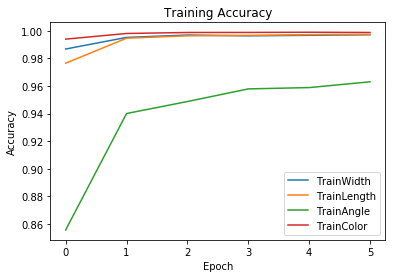

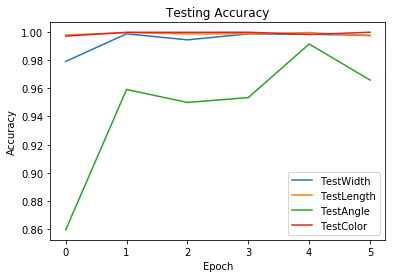

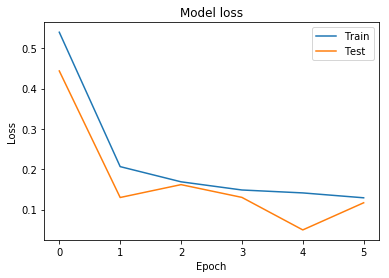

In [89]:
if not os.path.exists(op_folder):
    os.makedirs(op_folder)
    
print history.history.keys()

# Plot training accuracy values
plt.plot(history.history['widthB_acc'])
plt.plot(history.history['lengthB_acc'])
plt.plot(history.history['angleB_acc'])
plt.plot(history.history['colorB_acc'])

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['TrainWidth', 'TrainLength', 'TrainAngle', 'TrainColor'], loc='lower right')
plt.savefig(op_folder + "/train_acc.png", bbox_inches='tight')
plt.show()

# Plot validating accuracy values
plt.plot(history.history['val_widthB_acc'])
plt.plot(history.history['val_lengthB_acc'])
plt.plot(history.history['val_angleB_acc'])
plt.plot(history.history['val_colorB_acc'])

plt.title('Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['TestWidth', 'TestLength', 'TestAngle', 'TestColor'], loc='lower right')
plt.savefig(op_folder + "/test_acc.png", bbox_inches='tight')
plt.show()

# # Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(op_folder + "/loss.png", bbox_inches='tight')
plt.show()

In [164]:
# Final evaluation of the model
y_pred_length, y_pred_width, y_pred_color, y_pred_angle = model.predict(X_test)


In [178]:
y_pred_length = y_pred_length > 0.5
y_test_length = y_test_length > 0.5

y_pred_width = y_pred_width > 0.5
y_test_width = y_test_width > 0.5

y_pred_color = y_pred_color > 0.5
y_test_color = y_test_color > 0.5

y_test_length = y_test_length.reshape(y_pred_length.shape)
y_test_width = y_test_length.reshape(y_pred_width.shape)
y_test_color = y_test_length.reshape(y_pred_color.shape)

cm_length = getCM(y_test_length, y_pred_length)
cm_width = getCM(y_test_width, y_pred_width)
cm_color = getCM(y_test_color, y_pred_color)
cm_angle = confusion_matrix(y_test_angle.argmax(axis=1), y_pred_angle.argmax(axis=1))
# print cm_length
# print cm_width
# print cm_color
print cm_angle

# print y_pred_length.argmax(axis=1), y_test_length
# fscore = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
# precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
# recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
acc_len = accuracy_score(y_test_length.argmax(axis=1), y_pred_length.argmax(axis=1))
acc_wid = accuracy_score(y_test_width.argmax(axis=1), y_pred_width.argmax(axis=1))
acc_color = accuracy_score(y_test_color.argmax(axis=1), y_pred_color.argmax(axis=1))
acc_angle = accuracy_score(y_test_angle.argmax(axis=1), y_pred_angle.argmax(axis=1))

fs_len = f1_score(y_test_length.argmax(axis=1), y_pred_length.argmax(axis=1), average='macro')
fs_wid = f1_score(y_test_width.argmax(axis=1), y_pred_width.argmax(axis=1), average='macro')
fs_color = f1_score(y_test_color.argmax(axis=1), y_pred_color.argmax(axis=1), average='macro')
fs_angle = f1_score(y_test_angle.argmax(axis=1), y_pred_angle.argmax(axis=1), average='macro')

print "Accuracy: Len, Wid, Color, Angle"
print acc_len, acc_wid, acc_color, acc_angle
print fs_len, fs_wid, fs_color, fs_angle

np.savetxt(op_folder + "/cm_angle.txt", cm_angle, fmt="%d")
with open(op_folder + "/scores.txt", 'w') as the_file:
    the_file.write("Accuracy:\nLen " + str(acc_len) + 
                  "\nWid " + str(acc_wid) + 
                  "\nColor " + str(acc_color) +
                  "\nAngle " + str(acc_angle) + 
                  "\nFScore:\nLen " + str(fs_len) + 
                  "\nWid: " + str(fs_wid) + 
                  "\nColor: " + str(fs_color) +
                  "\nAngle: " + str(fs_angle))

[[3082   28    0    0    0    0    0    0    0    0    0   90]
 [  15 3175    0    0    0    0    0    0    0    0    0   10]
 [   0  144 3056    0    0    0    0    0    0    0    0    0]
 [   0    0  326 2870    4    0    0    0    0    0    0    0]
 [   0    0    8    0 3134   57    0    0    1    0    0    0]
 [   0    3    0    0    0 3175   19    3    0    0    0    0]
 [   0    0    0    0    0   24 3127   38    0    0    0   11]
 [   0    0    0    0    0    0    0 3191    0    0    0    9]
 [   0    0    0    0    0    0    0   59 3129    1   10    1]
 [   0    0    0    0    0    0    0    0    6 2909  285    0]
 [   0    0    0    0    0    0    0    0    0    0 3040  160]
 [   0    0    0    0    0    0    0    0    0    0    0 3200]]
Accuracy: Len, Wid, Color, Angle
1.0 1.0 1.0 0.9658333333333333
1.0 1.0 1.0 0.9659088076281012
